- In this notebook we compute popular maesure Risks such as Value at Risk(VaR) and Conditional VaR(CVaR), using historical stock data, parametric fitting and finally Monte Carlo Simulations. We extract stock data using the yfinance package.
- For the first part, we ignore asset correlations, and fit a univariate distribution to the aggregated portfolio returns. In the second part we use multivariate distributions.
- The goals are:
    - Fit historical data to normal and t distrib'utions, and compare their risk metric predictions.
    - Compare the effect of asset correlations by fitting the data to a multivariate distribution, including:
        

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats

In [2]:
import pandas as pd
import yfinance as yf
import time

tickers = ['AAPL', 'MSFT', 'GOOG', 'NVDA', 'AMZN']
start_date = '2010-01-01'
end_date = '2019-12-01'

adj_close_data = {}

for ticker in tickers:
    print(f"Downloading {ticker}...")
    t = yf.Ticker(ticker)
    df = t.history(start=start_date, end=end_date)
    adj_close_data[ticker] = df['Close']  # or 'Adj Close' if available
    time.sleep(0.5)  # optional delay

# Combine into dataframe
data = pd.DataFrame(adj_close_data)
print(data.head())


                               AAPL       MSFT       GOOG      NVDA    AMZN
Date                                                                       
2010-01-04 00:00:00-05:00  6.431896  23.211435  15.517998  0.423854  6.6950
2010-01-05 00:00:00-05:00  6.443017  23.218935  15.449662  0.430044  6.7345
2010-01-06 00:00:00-05:00  6.340531  23.076448  15.060195  0.432794  6.6125
2010-01-07 00:00:00-05:00  6.328810  22.836460  14.709600  0.424313  6.5000
2010-01-08 00:00:00-05:00  6.370887  22.993958  14.905696  0.425230  6.6760


In [3]:
data.tail()

,AAPL,MSFT,GOOG,NVDA,AMZN
Date,,,,,
2019-11-22 00:00:00-05:00,63.295078,142.532669,64.384285,5.245522,87.286003
2019-11-25 00:00:00-05:00,64.404900,144.095291,64.948441,5.502213,88.692001
2019-11-26 00:00:00-05:00,63.901989,144.857559,65.289413,5.397497,89.847000
2019-11-27 00:00:00-05:00,64.760323,145.133865,65.261574,5.432346,90.925499
2019-11-29 00:00:00-05:00,64.617699,144.238235,64.862450,5.395008,90.040001


In [4]:
data.shape

(2495, 5)

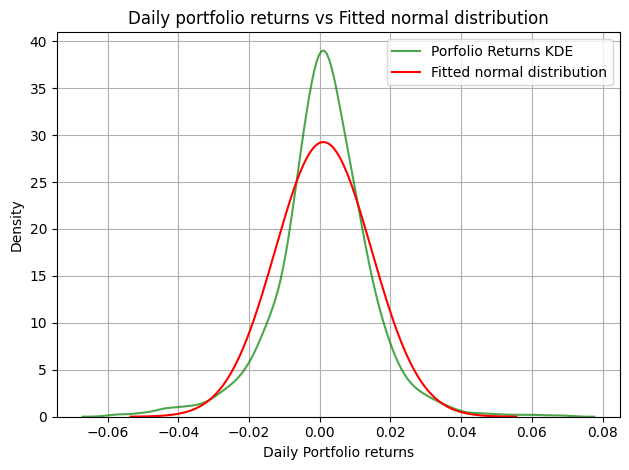

In [5]:
# returns = data.pct_change().dropna()
returns = data.pct_change().dropna()

# Portfolio weights (equal weights as example)
weights = np.array([1/len(tickers)] * len(tickers))

# Portfolio daily returns -
portfolio_returns = returns.dot(weights)
mean = portfolio_returns.mean()
std_dev = portfolio_returns.std()
import seaborn as sns
sns.kdeplot(portfolio_returns, color='green', fill=False, alpha=0.7, label='Porfolio Returns KDE')
from scipy.stats import norm
x=np.linspace(mean-4*std_dev,mean+4*std_dev,1000)
plt.plot(x,norm.pdf(x, mean, std_dev),'r-', label='Fitted normal distribution')
plt.title('Daily portfolio returns vs Fitted normal distribution')
plt.xlabel('Daily Portfolio returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
returns.head()

,AAPL,MSFT,GOOG,NVDA,AMZN
Date,,,,,
2010-01-05 00:00:00-05:00,0.001729,0.000323,-0.004404,0.014603,0.005900
2010-01-06 00:00:00-05:00,-0.015907,-0.006137,-0.025209,0.006397,-0.018116
2010-01-07 00:00:00-05:00,-0.001849,-0.010400,-0.023280,-0.019597,-0.017013
2010-01-08 00:00:00-05:00,0.006649,0.006897,0.013331,0.002161,0.027077
2010-01-11 00:00:00-05:00,-0.008822,-0.012720,-0.001512,-0.014016,-0.024041


In [7]:
from scipy.stats import shapiro
stat, p_value = shapiro(portfolio_returns)
print(f"Shapiro-Wilk p-value: {p_value:.4f}")


Shapiro-Wilk p-value: 0.0000


In [8]:
returns.shape

(2494, 5)

## It looks like a bad fit, the p value is 0. Thus we can reject the null hypothesis(that the data is drawn from a normal)

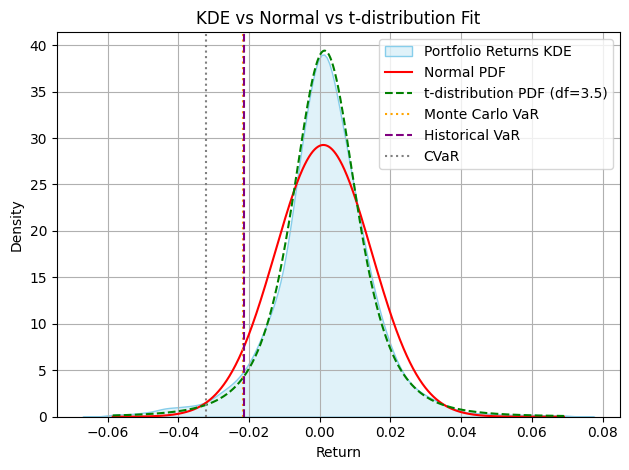

In [11]:
from scipy.stats import t

# Fit a t-distribution to portfolio returns
df, loc, scale = t.fit(portfolio_returns)

# Compare fit with KDE and normal
x = np.linspace(portfolio_returns.min(), portfolio_returns.max(), 1000)

sns.kdeplot(returns_AAPL, fill=True, color='skyblue', label='Portfolio Returns KDE')
plt.plot(x, norm.pdf(x, loc=mean, scale=std_dev), 'r-', label='Normal PDF')
plt.plot(x, t.pdf(x, df, loc=loc, scale=scale), 'g--', label=f't-distribution PDF (df={df:.1f})')
plt.axvline(mc_VaR, color='orange', linestyle=':', label='Monte Carlo VaR')
plt.axvline(hist_VaR, color='purple', linestyle='--', label='Historical VaR')
plt.axvline(CVaR, color='grey', linestyle=':', label='CVaR')

plt.title("KDE vs Normal vs t-distribution Fit")
plt.xlabel("Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [49]:


# Fit both
df_t, loc_t, scale_t = t.fit(returns_AAPL)
loc_n, scale_n = norm.fit(returns_AAPL)

# Compute log-likelihoods
loglik_t = np.sum(t.logpdf(returns_AAPL, df_t, loc_t, scale_t))
loglik_n = np.sum(norm.logpdf(returns_AAPL, loc_n, scale_n))

# AIC = 2k - 2logL  (k = number of parameters)
AIC_t = 2*3 - 2*loglik_t  # t has 3 parameters
AIC_n = 2*2 - 2*loglik_n  # normal has 2 parameters

print(f"AIC (t): {AIC_t:.2f}")
print(f"AIC (normal): {AIC_n:.2f}")


AIC (t): -13807.79
AIC (normal): -13465.93


In [48]:
from scipy.stats import kstest, t

# Perform K-S test for normal distribution
ks_stat_n, ks_p_n = kstest(returns_AAPL, 'norm', args=(mean, std_dev))
print(f"KS statistic (normal): {ks_stat_n:.4f}, p-value: {ks_p_n:.4f}")

# Perform K-S test
ks_stat, ks_p = kstest(returns_AAPL, 't', args=(df, loc, scale))
print(f"KS statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")


KS statistic (normal): 0.0346, p-value: 0.0050
KS statistic: 0.0506, p-value: 0.0000


## The KS Statistic is lower and the p-value is higher for the t-distribution, indicating a better fit than the normal distribution.

In [12]:
#  Parametric VaR (Variance-Covariance, assuming t) 
param_VaR_t = stats.t.ppf(1 - confidence_level, df, loc, scale)

#  Monte Carlo VaR (simulate 10,000 scenarios) 
n_simulations = 10000
simulated_returns = loc + scale * np.random.standard_t(df, size=n_simulations)
mc_VaR_t = np.percentile(simulated_returns, (1-confidence_level)*100)

t_CVaR = simulated_returns[simulated_returns <= mc_VaR_t].mean()

# Print results
print(f"=== Portfolio Risk Metrics with t-distribution ({confidence_level*100:.0f}% confidence) ===")
print(f"Parametric VaR_t: {param_VaR_t:.4f}")
print(f"Monte Carlo VaR_t: {mc_VaR_t:.4f}")
print(f"Monte Carlo CVaR (95%): {t_CVaR:.4f}")



=== Portfolio Risk Metrics with t-distribution (95% confidence) ===
Parametric VaR_t: -0.0197
Monte Carlo VaR_t: -0.0197
Monte Carlo CVaR (95%): -0.0325


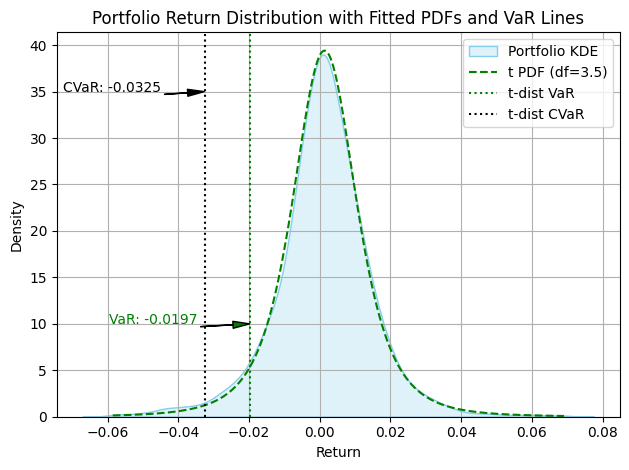

In [43]:
# Dashboard plot
x = np.linspace(portfolio_returns.min(), portfolio_returns.max(), 1000)
sns.kdeplot(portfolio_returns, fill=True, color='skyblue', label='Portfolio KDE')
plt.plot(x, t.pdf(x, df, loc=loc, scale=scale), 'g--', label=f't PDF (df={df:.1f})')

# VaR lines
plt.axvline(param_VaR_t, color='green', linestyle=':', label='t-dist VaR')
plt.axvline(t_CVaR,color='black', linestyle=':', label = 't-dist CVaR')
plt.annotate(f'VaR: {param_VaR_t:.4f}', xy=(param_VaR_t, 10), xytext=(param_VaR_t-0.04, 10), color ='green',
             arrowprops=dict(facecolor='green', shrink=0.01, width=0.1, headwidth=5))
plt.annotate(f'CVaR: {t_CVaR:.4f}', xy=(t_CVaR, 35), xytext=(t_CVaR-0.04, 35),
             arrowprops=dict(facecolor='black', shrink=0.01, width=0.1, headwidth=5))
plt.title('Portfolio Return Distribution with Fitted PDFs and VaR Lines')
plt.xlabel('Return')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Now lets study the stock prices individually, and see if their correlations have an impact on the final predictions

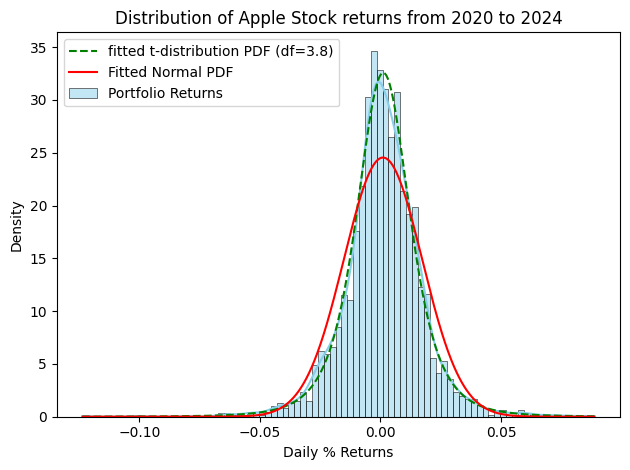

In [14]:
df,loc,scale = t.fit(returns['AAPL'])
fitted_norm=norm.fit(returns['AAPL'])
x= np.linspace(returns['AAPL'].min(), returns['AAPL'].max(), 1000)
sns.histplot(returns['AAPL'], kde=True, stat='density', color='skyblue', label='Portfolio Returns')
plt.plot(x, t.pdf(x, df, loc=loc, scale=scale), 'g--', label=f'fitted t-distribution PDF (df={df:.1f})')
plt.plot(x, norm.pdf(x, loc=fitted_norm[0], scale=fitted_norm[1]), 'r-', label='Fitted Normal PDF')
plt.legend()
plt.title('Distribution of Apple Stock returns from 2020 to 2024')
plt.xlabel('Daily % Returns')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

In [47]:
returns_AAPL = returns['AAPL']
df_t, loc_t, scale_t = t.fit(portfolio_returns)
loc_n, scale_n = norm.fit(portfolio_returns)

# Compute log-likelihoods
loglik_t = np.sum(t.logpdf(portfolio_returns, df_t, loc_t, scale_t))
loglik_n = np.sum(norm.logpdf(portfolio_returns, loc_n, scale_n))

# AIC = 2k - 2logL  (k = number of parameters)
AIC_t = 2*3 - 2*loglik_t  # t has 3 parameters
AIC_n = 2*2 - 2*loglik_n  # normal has 2 parameters

print(f"AIC (t): {AIC_t:.2f}")
print(f"AIC (normal): {AIC_n:.2f}")

AIC (t): -13807.79
AIC (normal): -13465.93


In [50]:
ks_stat_n, ks_p_n = kstest(returns_AAPL, 'norm', args=(mean, std_dev))
print(f"KS statistic (normal): {ks_stat_n:.4f}, p-value: {ks_p_n:.4f}")

# Perform K-S test
ks_stat, ks_p = kstest(returns_AAPL, 't', args=(df, loc, scale))
print(f"KS statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")


KS statistic (normal): 0.0346, p-value: 0.0050
KS statistic: 0.0506, p-value: 0.0000


## Both tests failed! But we care more about tail fits than global fits

In [ ]:
alpha = 0.05
empirical_var = np.percentile(returns_AAPL, 100*alpha)
model_var_t = t.ppf(alpha, df, loc, scale)
model_var_norm = norm.ppf(alpha, loc=loc_n, scale=scale_n)
print("Empirical VaR:", empirical_var)
print("Model VaR (t):", model_var_t)
print("Model VaR (normal):", model_var_norm)

Empirical VaR: -0.025046598985941804
Model VaR (t): -0.02814798420815703
Model VaR (normal): -0.02567786613155281


## The normal approximates the tails better

Text(0.5, 1.02, 'Pairplot of Stock Returns')

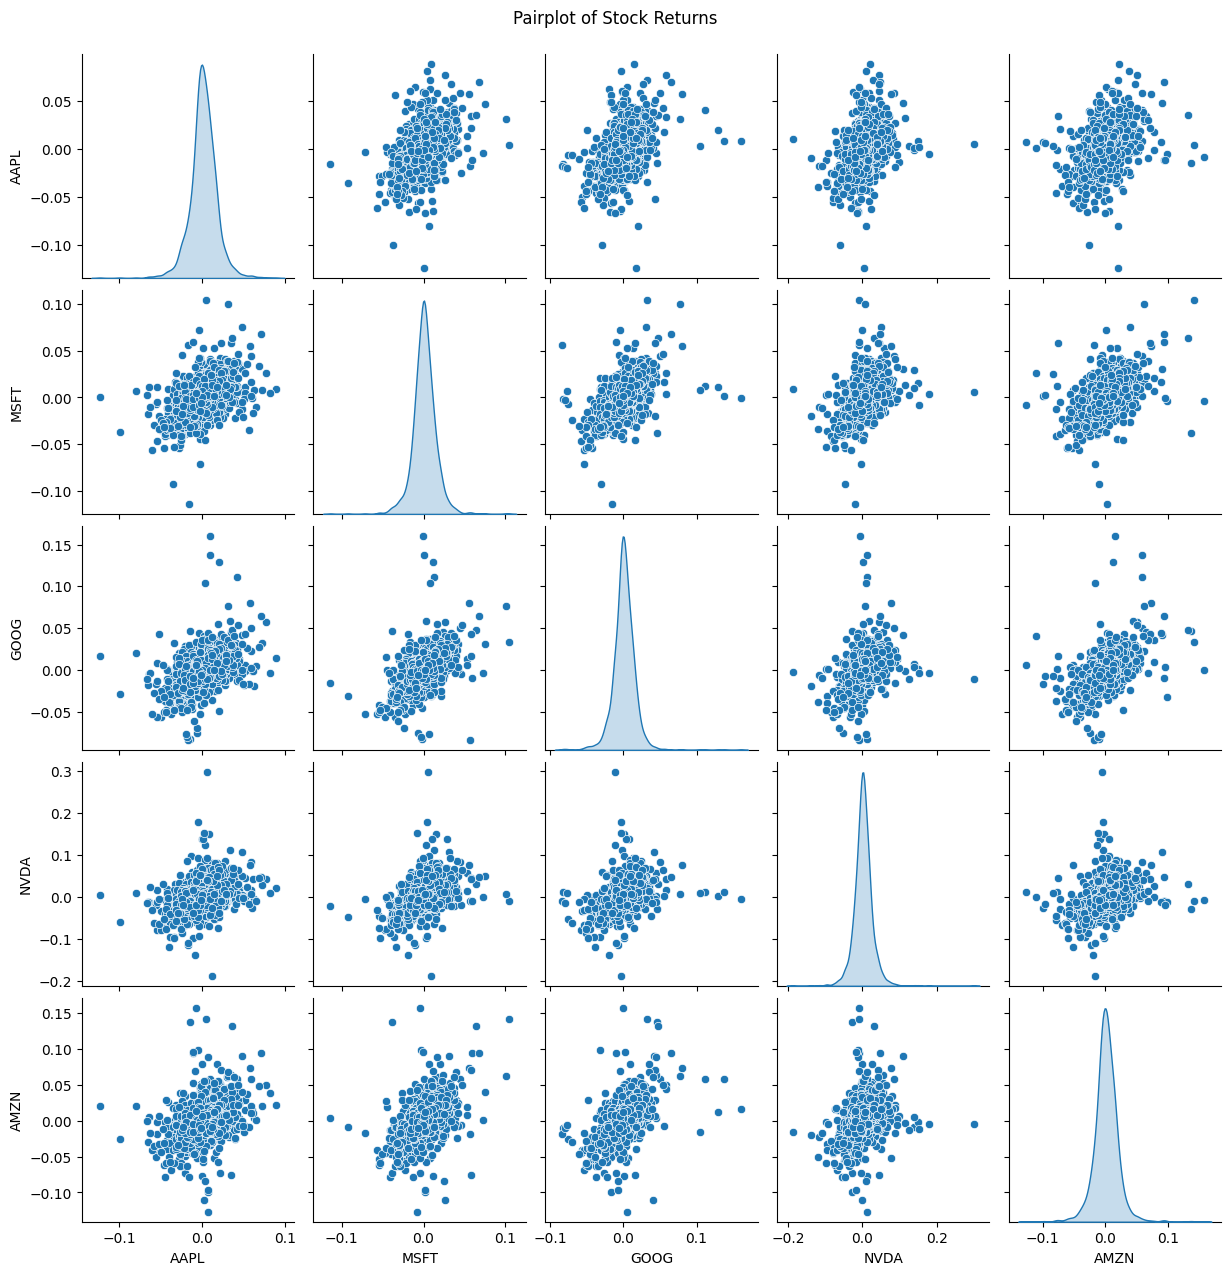

In [15]:
sns.pairplot(returns, diag_kind='kde', markers='o')
plt.suptitle('Pairplot of Stock Returns', y=1.02)

## As we can see, all the stocks are strongly correlated with one another

Text(0.5, 1.0, 'Correlation Matrix of Stock Returns')

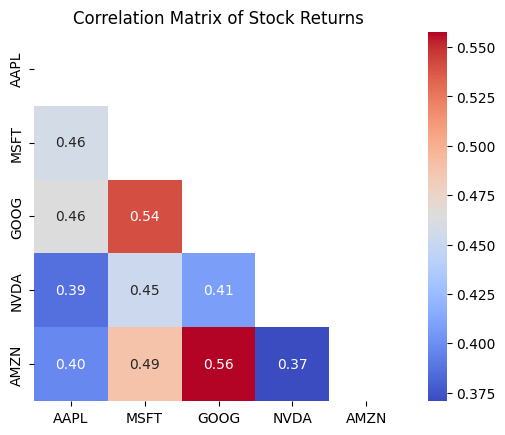

In [16]:

mask= np.triu(np.ones_like(returns.corr(), dtype=bool))
mask2 = returns.corr().abs() <= 1
sns.heatmap(returns.corr(), mask=mask & mask2,annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix of Stock Returns')

In [17]:
import numpy as np

n_samples = 10000
df = 3.7  # degrees of freedom (low df = fat tails)

# mean vector and covariance matrix from your return data
mean_vec = returns.mean().values           # shape: (n_assets,)
cov_matrix = returns.cov().values          # shape: (n_assets, n_assets)
n_assets = len(mean_vec)

# === Step 2: Simulate from multivariate normal ===
z = np.random.multivariate_normal(mean=mean_vec, cov=cov_matrix, size=n_samples)  # shape: (n_samples, n_assets)

#=== Step 3: Scale by sqrt of Gamma to get t-distribution ===
g = np.random.gamma(df / 2., 2. / df, size=n_samples)  # shape: (n_samples,)
scaling = np.sqrt(g)[:, None]  # reshape for broadcasting

# Simulate multivariate t
mvt_samples = mean_vec + (z - mean_vec) / scaling  # shape: (n_samples, n_assets)



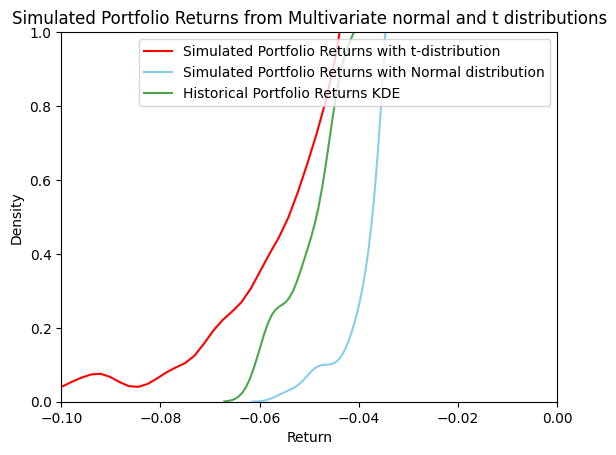

In [44]:
#mvt_samples.shape
portfolio_returns_mvt = mvt_samples.dot(weights)
portfolio_returns_normal= z.dot(weights)  # shape: (n_samples,)
df, loc, scale = t.fit(portfolio_returns_mvt)
mean, std_dev = norm.fit(portfolio_returns_normal)
sns.kdeplot(portfolio_returns_mvt, color='red', label='Simulated Portfolio Returns with t-distribution')
sns.kdeplot(portfolio_returns_normal, color='skyblue', label='Simulated Portfolio Returns with Normal distribution')
sns.kdeplot(portfolio_returns, color='green', fill=False, alpha=0.7, label='Historical Portfolio Returns KDE')
#plt.plot(x, , 'g--', label=f'Multivariate normal-distribution PDF (df={df:.1f})')
plt.title('Simulated Portfolio Returns from Multivariate normal and t distributions')
plt.xlim(-0.1, 0)
plt.ylim(0,1)
plt.xlabel('Return')    
plt.ylabel('Density')
plt.legend()    
plt.show()  

### The normal distribution underesimates the tail, so we take the t distribution

=== Portfolio Risk Metrics with Multivariate t-distribution (95% confidence) ===
VaR_mvn: -0.0212
CVaR_mvn: -0.0271


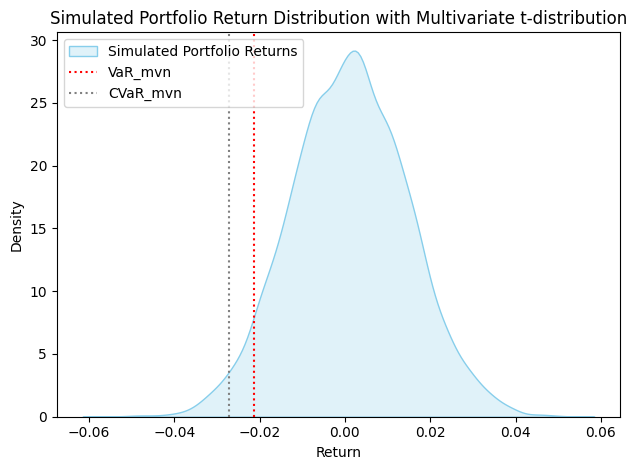

In [19]:
VaR_mvn = np.percentile(portfolio_returns_normal, (1-confidence_level)*100)
CVaR_mvn = portfolio_returns_normal[portfolio_returns_normal <= VaR_mvn].mean()
print(f"=== Portfolio Risk Metrics with Multivariate t-distribution ({confidence_level*100:.0f}% confidence) ===")
print(f"VaR_mvn: {VaR_mvn:.4f}")            
print(f"CVaR_mvn: {CVaR_mvn:.4f}")
# Dashboard plot        
x = np.linspace(portfolio_returns_normal.min(), portfolio_returns_normal.max(), 1000)
sns.kdeplot(portfolio_returns_normal, fill=True, color='skyblue', label='Simulated Portfolio Returns')
#plt.plot(x, no.pdf(x, df, loc=loc, scale=scale), 'g--', label=f't-distribution PDF (df={df:.1f})')
plt.axvline(VaR_mvn, color='red', linestyle=':', label='VaR_mvn')
plt.axvline(CVaR_mvn, color='grey', linestyle=':', label='CVaR_mvn')
plt.title('Simulated Portfolio Return Distribution with Multivariate t-distribution')
plt.legend()
plt.xlabel('Return')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


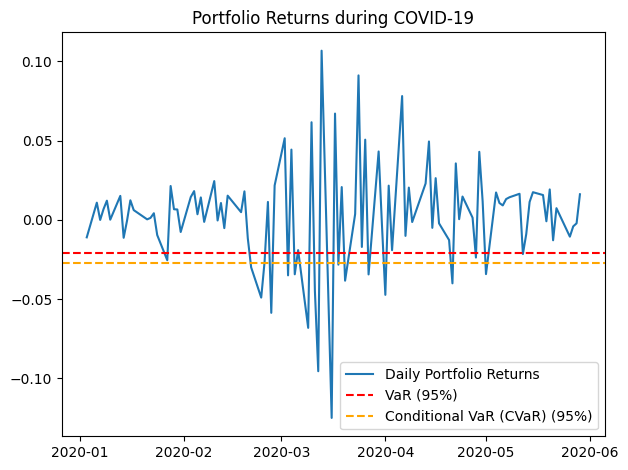

In [20]:
covid_data = yf.download(tickers, start="2020-01-01", end="2020-06-01")['Close']
covid_returns = covid_data.pct_change().dropna().dot(weights)

plt.plot(covid_returns.index, covid_returns, label='Daily Portfolio Returns')
plt.axhline(y=VaR_mvn, color='red', linestyle='--', label=f'VaR ({confidence_level*100:.0f}%)')
plt.axhline(y=CVaR_mvn, color='orange', linestyle='--', label=f'Conditional VaR (CVaR) ({confidence_level*100:.0f}%)')
plt.title('Portfolio Returns during COVID-19')
plt.legend()
plt.tight_layout()
plt.show()

- Downloaded historical price data for a portfolio of large-cap tech stocks (AAPL, MSFT, GOOG, NVDA, AMZN) using yfinance.
- Computed monthly returns and constructed an equally weighted portfolio.
- Visualized the empirical distribution of portfolio returns and compared it to fitted normal and Student's t-distributions.
- Calculated Value at Risk (VaR) and Conditional VaR (CVaR) using historical, parametric (normal and t), and Monte Carlo simulation methods.
- Found that the t-distribution provides a better fit to the empirical return distribution, especially in the tails.
- Analyzed individual stock return distributions and visualized pairwise correlations using pairplots and heatmaps.
- Simulated portfolio returns using both multivariate normal and multivariate t-distributions to account for asset correlations.
- Observed that incorporating asset correlations and fat tails (via the multivariate t) significantly affects risk metrics, generally increasing estimated risk.
- Compared risk metrics (VaR, CVaR) across all methods and highlighted the importance of modeling both tail distributions and correlations in risk estimation.
- Applied the methodology to COVID-19 period data to observe risk under extreme market conditions.